##Grad-CAM-based Heat Mapping Application for Membrane Segmentation using U-Net

### Get U-Net Repo

In [1]:
!git clone https://github.com/chungtd89/unet # a fork of https://github.com/zhixuhao/unet

Cloning into 'unet'...
remote: Enumerating objects: 413, done.
remote: Total 413 (delta 0), reused 0 (delta 0), pack-reused 413
Receiving objects: 100% (413/413), 44.92 MiB | 41.52 MiB/s, done.
Resolving deltas: 100% (90/90), done.


### Import Libraries

In [2]:
import sys
sys.path.append('unet')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import data as d
import model as m

Using TensorFlow backend.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from google.colab import drive
from google.colab import files
from keras import backend as K
%matplotlib inline

In [4]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


### Train Network

In [5]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=False,
                    fill_mode='nearest')
myGene = d.trainGenerator(2,'unet/data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = m.unet()
model_checkpoint = m.ModelCheckpoint('unet/unet_membrane.hdf5', monitor='loss',verbose=3, save_best_only=True)
#model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint]) #original
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint], verbose=3)     #faster training






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


unet/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)





Epoch 1/5
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.






Epoch 00001: loss improved from inf to 0.24236, saving model to unet/unet_membrane.hdf5
Epoch 2/5

Epoch 00002: loss improved from 0.24236 to 0.17793, saving model to unet/unet_membrane.hdf5
Epoch 3/5

Epoch 00003: loss improved from 0.17793 to 0.15127, saving model to unet/unet_membrane.hdf5
Epoch 4/5

Epoch 00004: loss improved from 0.15127 to 0.13256, saving model to unet/unet_membrane.hdf5
Epoch 5/5

Epoch 00005: loss improved from 0.13256 to 0.11766, saving model to unet/unet_membrane.hdf5


In [6]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

### Test Model & Save Prediction Results

In [7]:
testGene = d.testGenerator("unet/data/membrane/test")
model = m.unet()
model.load_weights("unet/unet_membrane.hdf5")
results = model.predict_generator(testGene,10,verbose=3)
d.saveResult("unet/data/membrane/test",results)

unet/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [0]:
from keras.preprocessing import image
import numpy as np

# The local path to our target image
im_name = '2'
test_path = 'unet/data/membrane/test/'
path = test_path + im_name + '.png'

# `img` is a PIL image of size 256 x 256
img = image.load_img(path, target_size=(256, 256), color_mode="grayscale") #adjust according to model.summary input layer

# `x` is a float32 Numpy array of shape (256, 256, 1)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 256, 256, 1)
x = np.expand_dims(x, axis=0)

### Generate Heatmap

In [9]:
import cv2

# Predicted image
im_pred = model.output[:, 0] #index = 0 since there is only 1 output from the network
print("img_pred_shape = ", im_pred.shape)

# The output feature map of the `xxx` layer,
# The last convolutional layer in model
last_conv_layer = model.get_layer('up_sampling2d_5')

#=========DEPENDING ON LAYER, pooled_grads size varies, thus below range varies

# This is the gradient of the "membrane" class with regard to
# the output feature map of `xxx`
grads = K.gradients(im_pred, last_conv_layer.output)[0]
print("grads_shape = ", grads.shape)
# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `xxx`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
print("model.input_shape = ", model.input.shape) ####input_shape should align with x_shape
print("pooled_grads_shape = ", pooled_grads.shape)
print("last_conv_layer.output[0]_shape = ", last_conv_layer.output[0].shape)
a = [pooled_grads, last_conv_layer.output[0]]
print(pooled_grads[1])
# These are the values of these two quantities, as Numpy arrays
print("x_shape = ", x.shape)                     ####input_shape should align with x_shape
pooled_grads_value, conv_layer_output_value = iterate([x])
print("pooled_grads_value_shape = ", pooled_grads_value.shape)
print("conv_layer_output_value_shape = ", conv_layer_output_value.shape)
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the membrane class
#=========DEPENDING ON LAYER, pooled_grads size varies, thus below range varies
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
print("heatmap_shape = ", heatmap.shape)

img_pred_shape =  (?, 256, 1)
grads_shape =  (?, 32, 32, 1024)
model.input_shape =  (?, 256, 256, 1)
pooled_grads_shape =  (1024,)
last_conv_layer.output[0]_shape =  (32, 32, 1024)
Tensor("strided_slice_4:0", shape=(), dtype=float32)
x_shape =  (1, 256, 256, 1)
pooled_grads_value_shape =  (1024,)
conv_layer_output_value_shape =  (32, 32, 1024)
heatmap_shape =  (32, 32)


### Plot Heatmap

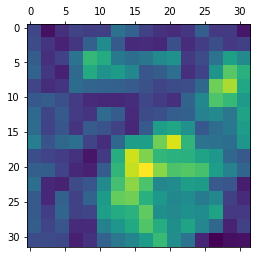

In [10]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Visualize Heatmap on Tested Image

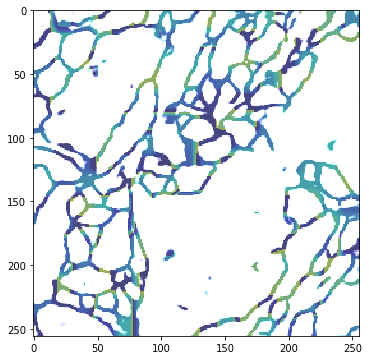

In [15]:
im_heat_path = test_path + im_name + '_heatmap.png'
img_path = "/content/unet/data/membrane/test/0_predict.png"

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite(im_heat_path, superimposed_img)

from PIL import Image
im = Image.open(im_heat_path)
fig=plt.figure(figsize=(8, 6))
plt.imshow(im)
plt.show()